# Invoice Royalty and Product Revenue
## Run on Monday Afternoon after Melissa has run her the Invoice Entries
- Four Separte Tables are needed
- Have to merge the the four tables in order to get accurate report
- Always use the Invoice Date as a starting point in the InvoiceHistoryHeader

In [1]:
import pandas as pd
import os
import numpy as np
import pyodbc as odbc
import datetime as dt
from datetime import date,timedelta,datetime
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import matplotlib.image as mpimg
os.chdir(r'G:\FinanceReports\2025\Wk12')
# plt.style.use('ggplot')

C:\Users\jharned\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\jharned\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
#Get Logo
img = mpimg.imread('Logo.png')

In [3]:
# # Make New Folder
os.mkdir(r'G:\FinanceReports\2025\Wk13')
# Change Directory
os.chdir(r'G:\FinanceReports\2025\Wk13')
# Add Logo to New Folder
plt.imsave('Logo.png', img)

In [4]:
os.getcwd()

'G:\\FinanceReports\\2025\\Wk13'

In [5]:
# Names the needed driver, server name, and database
driver_name='SQL Server'
server_name='10.0.1.127'
database='MAS_RFC'

In [6]:
#Creates the connection string
connection_string=f"""
DRIVER={{{driver_name}}};
SERVER={server_name};
DATABASE={database};
Trust_Connection=yes"""

In [7]:
connection=odbc.connect(connection_string)
print(connection)

In [8]:
# Four tables needed to run the report
# All four are needed in order run report
invoice_history=pd.read_sql_query("""SELECT * from MAS_RFC.dbo.AR_InvoiceHistoryHeader Where Year(InvoiceDate)>=2022""",connection)
customer=pd.read_sql_query('''select * from MAS_RFC.dbo.AR_Customer''',connection)
invoice_detail=pd.read_sql_query('''select InvoiceNo,ItemCode,ItemCodeDesc,ItemType,UnitPrice,QuantityShipped, UDF_ROYALTY_AMT,UDF_STD_UNIT_PRICE,ProductLine,CommentText from MAS_RFC.dbo.AR_InvoiceHistoryDetail''',connection)
product_line=pd.read_sql_query('''select * from MAS_RFC.dbo.IM_ProductLine''',connection)

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1092709825.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  invoice_history=pd.read_sql_query("""SELECT * from MAS_RFC.dbo.AR_InvoiceHistoryHeader Where Year(InvoiceDate)>=2022""",connection)
C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1092709825.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer=pd.read_sql_query('''select * from MAS_RFC.dbo.AR_Customer''',connection)
C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1092709825.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please c

# The Code Below Creates the Invoice DataFrame
- This is meant to replicate the Excel File of the Same Name
- The block below represents grabbing the certain columns we need, creating new columns Ext Base Cost and Ext Roylaty\
  merging the tables together and filtering out particular things we don't need
- Important to drop duplicated rows and keeping only the first duplicate

In [9]:
# Grabs the necessary columns from Invoice History
inv_hist=invoice_history[['CustomerNo','InvoiceNo','InvoiceType','ShipDate','InvoiceDate','BillToState','InvoiceDueDate']]
# Merges Invoice History with Invoice Detail on InvoiceNo column
inv_merge=inv_hist.merge(invoice_detail,on='InvoiceNo',how='inner').drop_duplicates(keep='first')
inv_merge['Ext Base Cost']=inv_merge.QuantityShipped*inv_merge.UDF_STD_UNIT_PRICE
inv_merge['Ext Royalty']=inv_merge.QuantityShipped*inv_merge.UDF_ROYALTY_AMT
cust=customer[['CustomerNo','CustomerName','City','ARDivisionNo','UDF_ROYALTY_METHOD','UDF_DISTRIBUTOR']]
all_merge=inv_merge.merge(cust,on='CustomerNo',how='inner').drop_duplicates(keep='first')
filtered=all_merge[all_merge.ARDivisionNo=='01']
# filtered=all_merge[(all_merge.ItemType=='1')&(all_merge.ARDivisionNo=='01')]
total_df=filtered.merge(product_line[['ProductLine','ProductLineDesc']],on='ProductLine').drop_duplicates(keep='first')
total_df=total_df[total_df.InvoiceDate.dt.year<=2025]
total_df=total_df[(total_df.CustomerNo!='TRAINMS')&(total_df.CustomerNo!='EAGLES1')&(total_df.CustomerNo!='CANA001')]
total_df.loc[total_df.CustomerNo==1528,'BillToState']='PA'
state=['PA','NJ','DE','MD']

In [10]:
total_df.InvoiceDate.max()

Timestamp('2025-03-28 00:00:00')

In [11]:
# Names the needed driver, server name, and database
driver_name='SQL Server'
server_name='10.0.1.218'
database='ritascoolnet_live'
#Creates the connection string
connection_string=f"""
DRIVER={{{driver_name}}};
SERVER={server_name};
DATABASE={database};
Trust_Connection=yes"""
#Creates the Connection to SQL Server
connection=odbc.connect(connection_string)
print(connection)

In [12]:
# Pulls Marketing info needed like Coolnet Group, MSA, and DMA
data=pd.read_sql_query('''Select intstoreid as intStoreID,RitasID, FC,CoolNetGroup,LegacyStoreType,State,MSAName,DMA,StoreName as ShopName,CoOpName,OpenDate,StoreStatus,[Re Open Date] as ReOpenDate from ritascoolnet_live.dbo.vShopDetail''',
                        connection)
relo=pd.read_sql_query('''Select intStoreID,dteClosedForRelocation,intParentStoreID as ParentID,
intRitasStoreID as CustomerNo,bitDriveThru as DT from ritascoolnet_live.dbo.GOOGLE_MAP_store''',connection)
data=data.merge(relo[['intStoreID','dteClosedForRelocation']],on='intStoreID',how='left')
data=data.sort_values(by='intStoreID',ascending=False).drop_duplicates(subset='RitasID',keep='first')
data=data.rename(columns={'RitasID':'CustomerNo'})
data['dteClosedForRelocation']=pd.to_datetime(data['dteClosedForRelocation'])
data['Days']=(data.ReOpenDate-data.dteClosedForRelocation).dt.days
data['OpenDate']=np.where(data.Days>=365,data.ReOpenDate,data.OpenDate)

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\4141677903.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data=pd.read_sql_query('''Select intstoreid as intStoreID,RitasID, FC,CoolNetGroup,LegacyStoreType,State,MSAName,DMA,StoreName as ShopName,CoOpName,OpenDate,StoreStatus,[Re Open Date] as ReOpenDate from ritascoolnet_live.dbo.vShopDetail''',
C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\4141677903.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  relo=pd.read_sql_query('''Select intStoreID,dteClosedForRelocation,intParentStoreID as ParentID,


In [13]:
data.loc[data.CustomerNo==1502,'OpenDate']='2023-12-28'

In [14]:
total_df.shape

(1319315, 24)

In [15]:
#This adds the OpenDate to the Total_Df dataframe. There is some minor manipulation done in order to merge the OpenDate
#with the the Total_Df

total_df['CustomerNo']=total_df.CustomerNo.astype('int')
total_df=total_df.merge(data[['CustomerNo','OpenDate','StoreStatus']],on='CustomerNo',how='left')
total_df['OpenDate']=total_df.OpenDate.fillna('No Open Date')
total_df['OpenDate']=pd.to_datetime(total_df['OpenDate'],errors='coerce')
total_df.OpenDate.replace({pd.NaT: 'No Open Date'}, inplace=True)
total_df.loc[total_df.CustomerNo==1528,'BillToState']='PA'
total_df.loc[total_df.CustomerNo==1446,'BillToState']='PA'
total_df.loc[total_df.CustomerNo==1468,'BillToState']='MD'
total_df.loc[total_df.CustomerNo==1515,'BillToState']='AL'
total_df.loc[total_df.CustomerNo==1397,'BillToState']='AL'
total_df.loc[total_df.CustomerNo==1337,'BillToState']='FL'

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\3158665591.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  total_df.OpenDate.replace({pd.NaT: 'No Open Date'}, inplace=True)


In [16]:
total_df.InvoiceDate.max()

Timestamp('2025-03-28 00:00:00')

# The next several lines of code are merely visualizations of the Invoice Date and are not part of the Invoice Report

In [17]:
#Type in the Month you wish to view
month=input('Enter Desired Month to View: ')

Enter Desired Month to View: March


C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\3652198402.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)


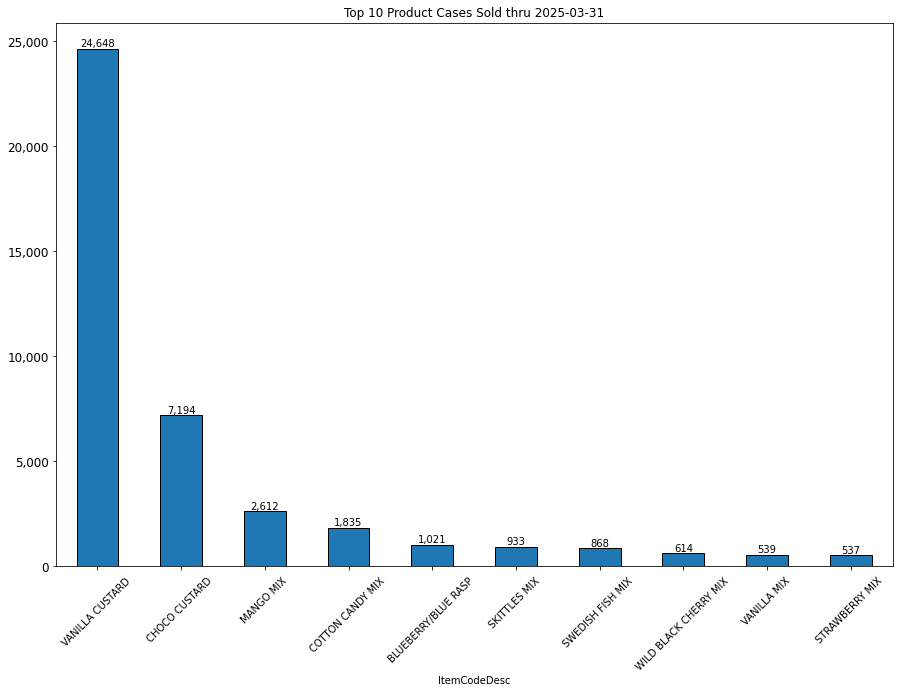

In [18]:
# Top 10 Product Sold YTD based on Today's Date
mixes=['CUSTARD','MIXES','CUSTARD - KOSHER','MIXES-SUGARFREE']
total_df['ItemCodeDesc']=total_df.ItemCodeDesc.str.split('(').str[0]
ax=total_df[total_df.ProductLineDesc.isin(mixes)&(total_df.InvoiceDate.dt.year==2025)].groupby(
    ['ItemCodeDesc'])['QuantityShipped'].sum().nlargest(10).plot(
kind='bar',figsize=(15,10),title='Top 10 Product Cases Sold thru '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
ax.yaxis.set_major_formatter('{:,.0f}'.format)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [19]:
mix=total_df[total_df.ProductLineDesc.isin(mixes)].groupby('ItemCodeDesc')['Ext Royalty'].sum().sort_values(ascending=False)
mix/mix.sum()*100

ItemCodeDesc
VANILLA CUSTARD                   37.461550
CHOCO CUSTARD                     10.433059
MANGO MIX                          9.582084
COTTON CANDY MIX                   5.356505
CHERRY MIX                         4.550767
BLUEBERRY/BLUE RASP                3.547527
LEMON BASE                         3.047847
SWEDISH FISH MIX                   2.915384
WILD BLACK CHERRY MIX              2.037804
STRAWBERRY MIX                     1.986838
CHOCOLATE MIX                      1.389776
ROOT BEER MIX                      1.368362
VANILLA MIX                        1.324179
WATERMELON MIX                     1.284184
GREEN APPLE                        1.237696
NEW GEORGIA PEACH MIX              1.078595
MINT CHOC CHIP CRM MIX             1.004665
PINA COLADA MIX                    0.844734
ISLAND FUSION MIX                  0.762818
COOKIES N' CREAM MIX               0.628426
SOUR PATCH KIDS MIX                0.591616
PINEAPPLE MIX                      0.574858
FLORIDA ORANGE MIX 

In [20]:
vol_price=total_df[(total_df.InvoiceDate.dt.year>=2024)&(total_df.InvoiceDate.dt.month<=3)&(total_df.ProductLineDesc.isin(mixes))]\
.pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values=['UDF_STD_UNIT_PRICE','QuantityShipped'],
                                                                aggfunc={'UDF_STD_UNIT_PRICE':'median',
                                                                         'QuantityShipped':'sum'},fill_value=0)
vol_price.columns = ['_'.join(map(str, col)).strip() for col in vol_price.columns]
vol_price['Revenue_24']=round(vol_price.iloc[:,0]*vol_price.iloc[:,2],2)
vol_price['Revenue_25']=round(vol_price.iloc[:,1]*vol_price.iloc[:,3],2)
vol_price['Chng_Rev']=vol_price.iloc[:,-1]-vol_price.iloc[:,-2]
vol_price.sort_values('Chng_Rev')


QuantityShipped_2024  QuantityShipped_2025  \
ItemCodeDesc                                                              
SOUR PATCH WATERMELON                      909.50                124.00   
KOSHER POWDERED VAN CUST                   222.00                  0.00   
UNICORN MIX                                234.00                  0.00   
CHEESECAKE MIX                             264.75                  0.00   
OCEAN SPLASH                               168.00                  0.00   
COOKIES N' CREAM MIX                       624.00                287.00   
KEY LIME MIX                               335.00                 53.00   
FLORIDA ORANGE MIX                         232.00                 50.00   
PINEAPPLE MIX                              211.00                 69.00   
CANTALOUPE MIX                             107.00                  0.00   
KOSHER POWDERED CHOC CUST                   55.00                  0.00   
SWEDISH FISH MIX                           974.75                868.00   
STRAWBERRY MIX                             666.75                537.00   
S'MORES MIX                                141.00                 80.00   
NEW GEORGIA PEACH MIX                      297.67                241.00   
VANILLA MIX                                648.00                539.00   
RASPBERRY MIX                              280.00                246.50   
BLUEBERRY/BLUE RASP                       1126.00               1021.00   
LEMON BASE                                 290.00                210.00   
ISLAND FUSION MIX                          303.00                258.00   
ROOT BEER MIX                              483.00                421.00   
MINT CHOC CHIP CRM MIX                     243.00                196.75   
GREEN APPLE                                492.00                443.00   
2.5 GAL VANILLA CUST CREDIT                 -2.00                -41.00   
PINA COLADA MIX                            256.00                227.00   
BIRTHDAY CAKE MIX                           34.00                 13.00   
SOUR PATCH KIDS MIX                        190.00                167.00   
TROPICAL PUNCH MIX                          13.00                  0.00   
CHERRY MIX                                 448.00                428.00   
BANANA MIX                                 134.00                118.00   
2.5 GAL CHOCO CUST CREDIT                   -6.00                -21.00   
CHOCOLATE MIX                              516.00                421.75   
WATERMELON MIX                             326.00                303.00   
WILD BLACK CHERRY MIX                      642.00                613.75   
GRAPE MIX                                    2.00                  0.00   
KLEINS CHOCO CUSTARD                        70.00                  0.00   
KLEINS VANILLA CUSTARD                     203.00                  0.00   
GUMMY BEAR MIX                              -1.00                  0.00   
COCONUT CREAM MIX                          174.00                168.75   
MANGO MIX                                 2736.00               2612.50   
COTTON CANDY MIX                          1890.50               1834.75   
CY POWDER CHOCO CUSTARD                     34.00                 48.00   
DISCOUNT PINEAPPLE MIX                       0.00                124.00   
NERDS MIX                                    0.00                 97.00   
DR.PEPPER MIX                               33.00                 95.00   
JUICY PEAR MIX                              24.00                148.00   
CY POWDER VANILLA CUSTARD                   41.00                174.00   
KOOL AID MIX                                 0.00                475.00   
COLA MIX                                     0.00                500.00   
CHOCO CUSTARD                             7343.50               7193.75   
SKITTLES MIX                                 0.00                933.00   
VANILLA CUSTARD                          23812.00     

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\2101798982.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)


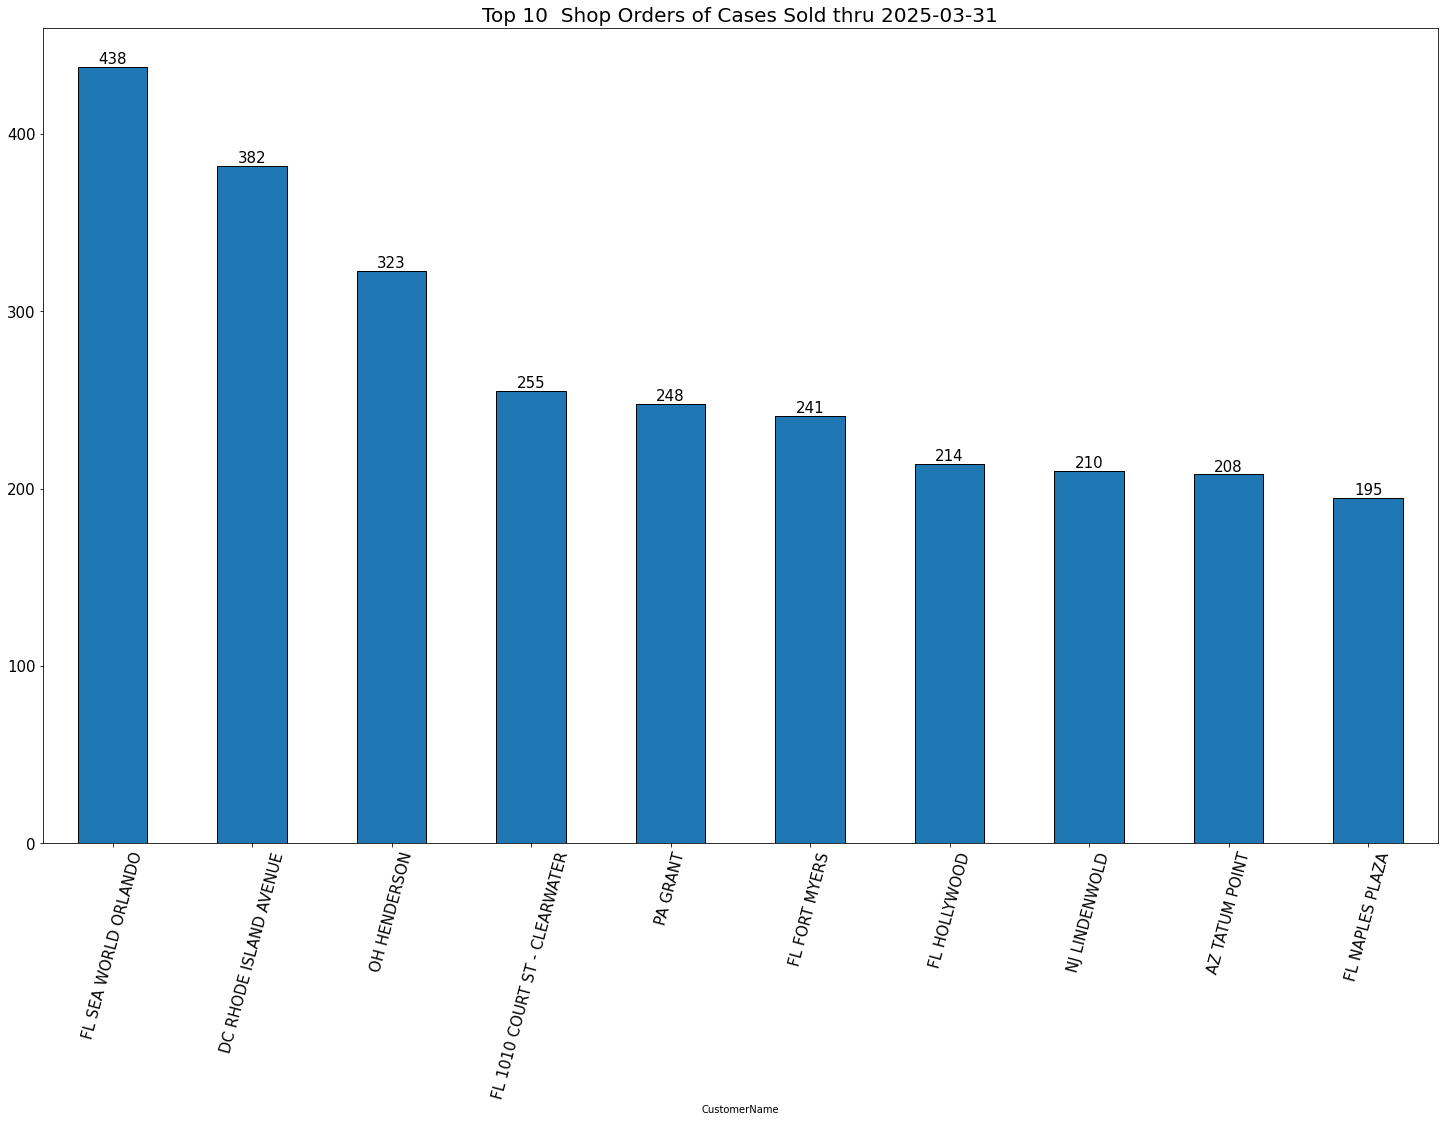

In [21]:
# Top 10 Shops who have ordered the most cases

ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2025)].groupby(
    ['CustomerName'])['QuantityShipped'].sum().nlargest(10).plot(
kind='bar',figsize=(25,15),title='Top 10  Shop Orders of Cases Sold thru '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fontsize=15,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75,fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)
ax.yaxis.set_major_formatter('{:,.0f}'.format)
ax.set_title('Top 10  Shop Orders of Cases Sold thru '+str(date.today()),fontsize=20);

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\4273075320.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45);


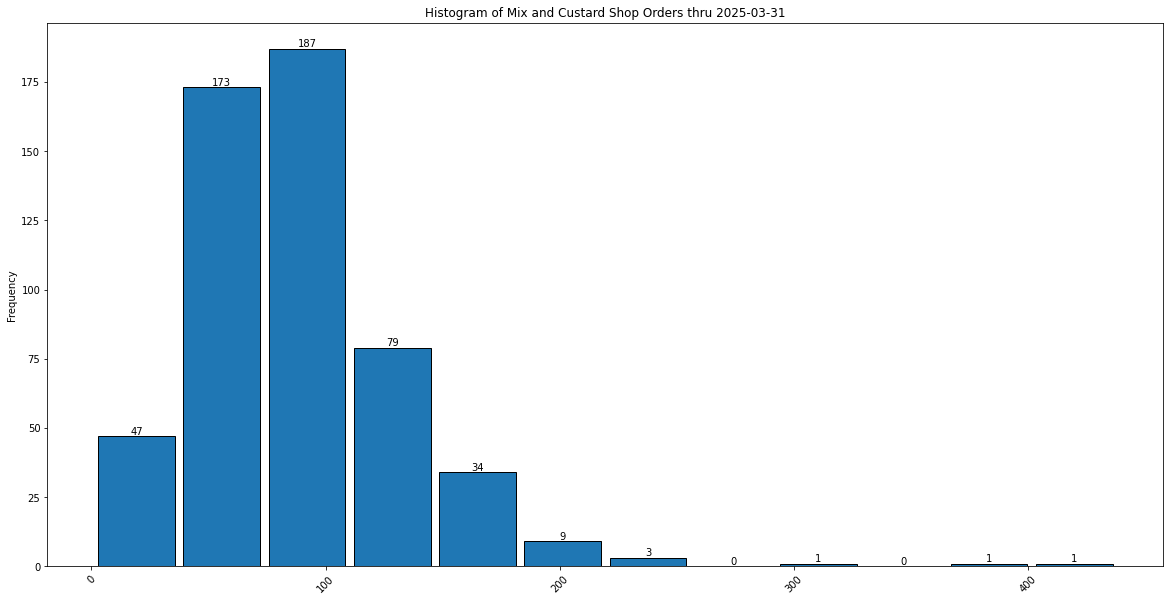

In [22]:
# Distribution of Shop Orders
ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2025)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().plot(
kind='hist',figsize=(20,10),title='Histogram of Mix and Custard Shop Orders thru '+str(date.today()),bins=12,rwidth=.9,
edgecolor='black')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\955528305.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45);


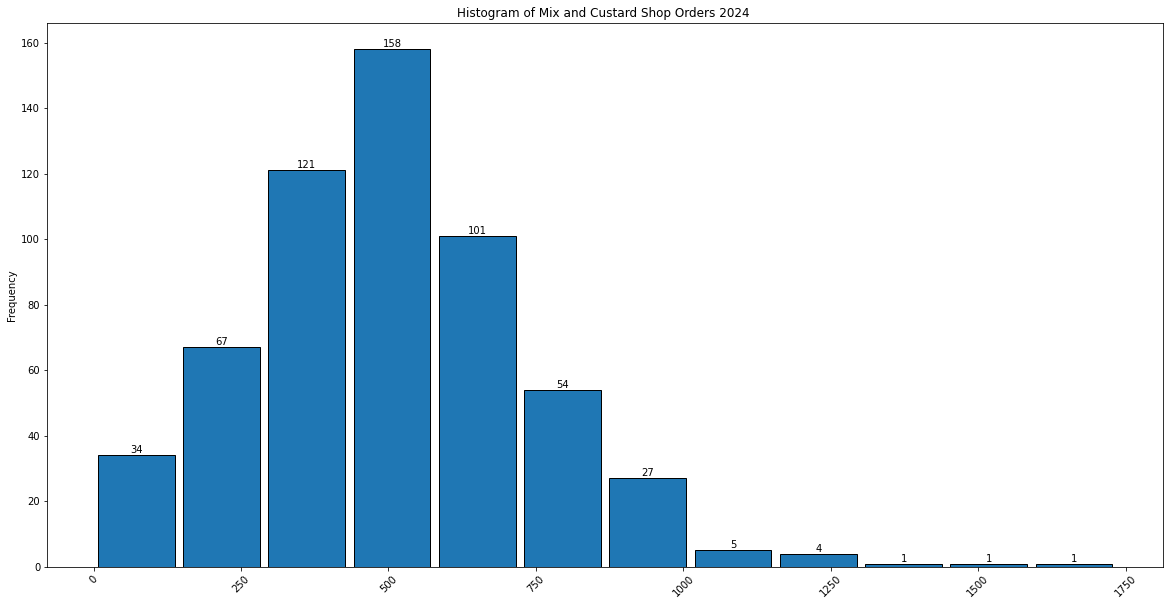

In [23]:
ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().plot(
kind='hist',figsize=(20,10),title='Histogram of Mix and Custard Shop Orders 2024 ',bins=12,rwidth=.9,
edgecolor='black')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [24]:
# Desription of the Histogram above
total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().describe()

count     574.000000
mean      503.294930
std       241.740216
min         0.000000
25%       344.500000
50%       490.500000
75%       641.875000
max      1735.000000
Name: QuantityShipped, dtype: float64

In [25]:
# test=total_df[(total_df.ProductLineDesc.isin(mixes))&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
#     ['CustomerName','Year'])['QuantityShipped'].sum().reset_index()
# sns.histplot(data=test[test.Year==2024],x='QuantityShipped',color='#C12637',bins=10,alpha=.5,label='2024')
# sns.histplot(data=test[test.Year==2023],x='QuantityShipped',color='#12703C',bins=10,alpha=.5,label='2023')
# plt.legend(loc='upper right')


In [26]:
# Desription of the Histogram above
total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2025)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().describe()

count    535.000000
mean      87.710280
std       45.968548
min        1.000000
25%       59.500000
50%       81.250000
75%      108.000000
max      438.000000
Name: QuantityShipped, dtype: float64

In [27]:
qs=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2025)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().reset_index()
qs[qs.QuantityShipped>(qs.QuantityShipped.mean()+(qs.QuantityShipped.std()*2))].sort_values(by='QuantityShipped',ascending=False)

CustomerName  QuantityShipped
77             FL SEA WORLD ORLANDO            438.0
29           DC RHODE ISLAND AVENUE            382.0
305                    OH HENDERSON            323.0
47    FL 1010 COURT ST - CLEARWATER            255.0
411                        PA GRANT            248.0
66                    FL FORT MYERS            241.0
68                     FL HOLLYWOOD            214.0
242                   NJ LINDENWOLD            210.0
7                    AZ TATUM POINT            208.0
70                  FL NAPLES PLAZA            195.0
18                 CA SANTA CLARITA            191.0
525   VA BUSCH GARDENS WILLIAMSBURG            190.0
194  NJ 3638 E. LANDIS AVE-VINELAND            187.0
404                       PA FOLSOM            187.0
16                     CA SAN DIEGO            186.0

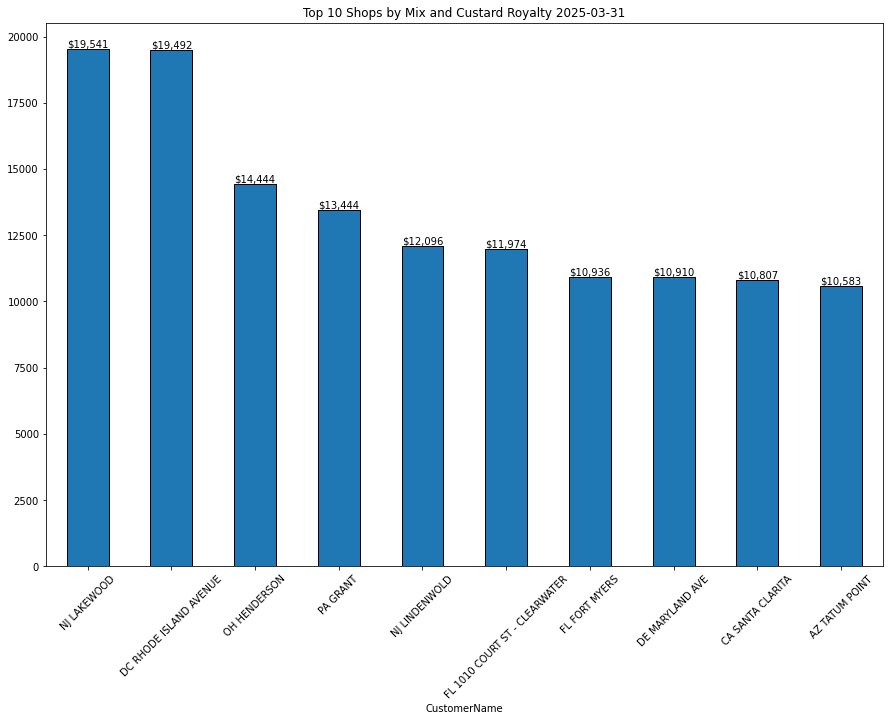

In [28]:
# Top 10 Shops Based on Royalty paid in Mixes and Custard YTD
ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2025)].groupby(
    ['CustomerName'])['Ext Royalty'].sum().nlargest(10).plot(
kind='bar',figsize=(15,10),title='Top 10 Shops by Mix and Custard Royalty '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

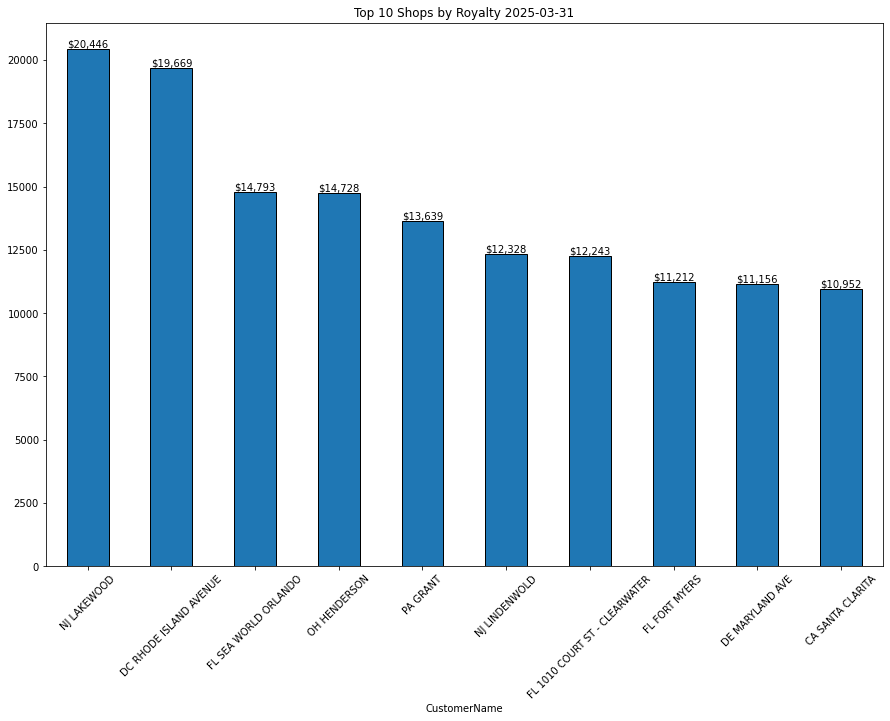

In [29]:
# Top 10 Shops in Total Royalty Paid YTD
ax=total_df[(total_df.InvoiceDate.dt.year==2025)].groupby(
    ['CustomerName'])['Ext Royalty'].sum().nlargest(10).plot(
kind='bar',figsize=(15,10),title='Top 10 Shops by Royalty '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [30]:
total_df[(total_df.InvoiceDate.dt.year==2025)].groupby(
    ['CustomerName'])['Ext Royalty'].sum().describe()

count      559.000000
mean      4555.149841
std       2523.708604
min          0.000000
25%       3063.275000
50%       4242.530000
75%       5758.540000
max      20445.810000
Name: Ext Royalty, dtype: float64

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\2215069681.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='InvoiceDate',freq='Y'))['QuantityShipped'].sum().plot(


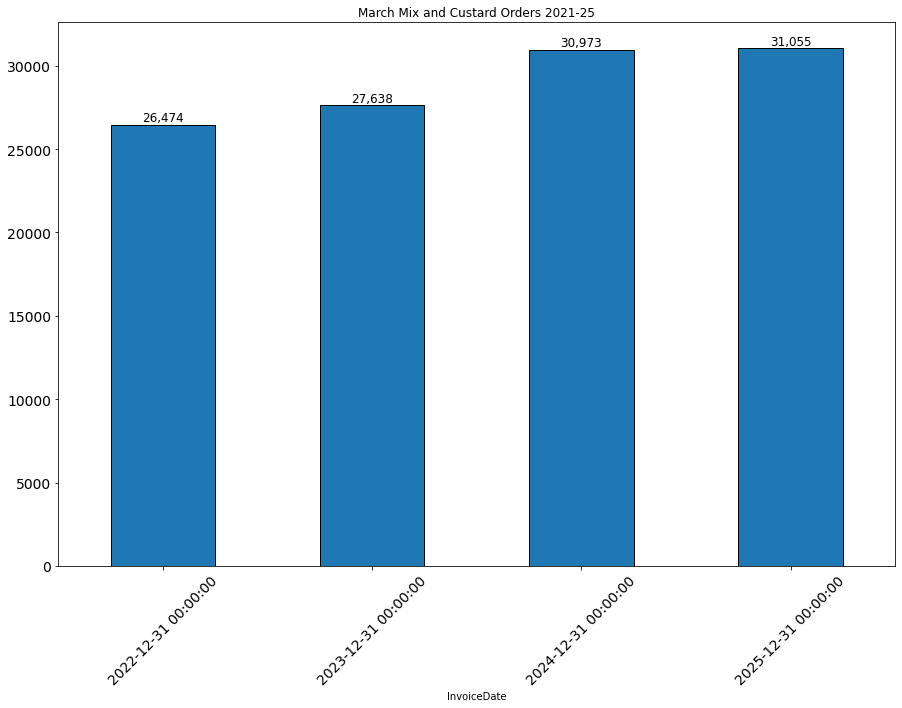

In [31]:
# Current Month Mix and Custard orders by Year
ax=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))['QuantityShipped'].sum().plot(
    kind='bar',edgecolor='black',figsize=(15,10),title=str(month)+' Mix and Custard Orders 2021-25',
fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\842731081.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','QuantityShipped']].agg({


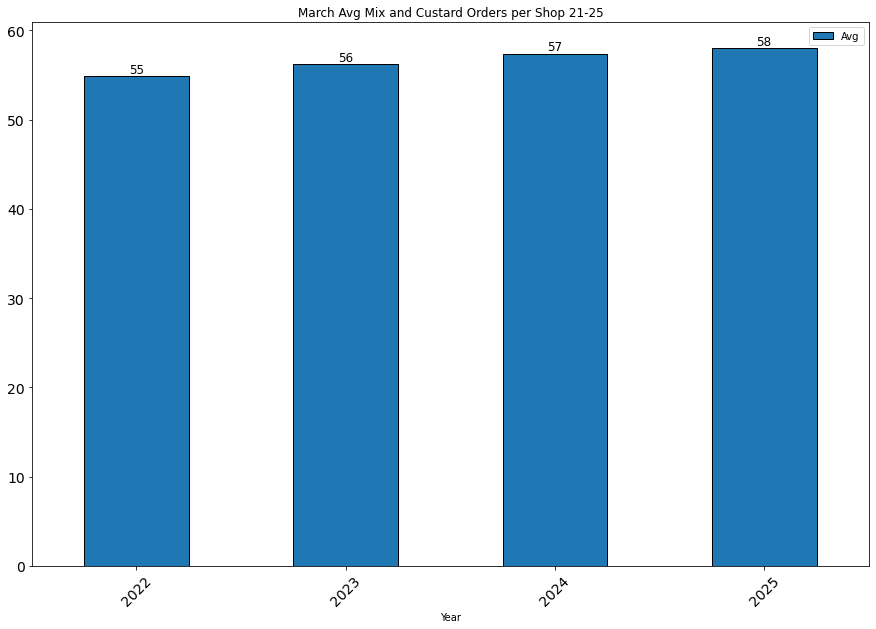

In [32]:
#Current Month Avg Mix and Custard order by Shop by Year
df=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','QuantityShipped']].agg({
        'CustomerNo':'nunique',
        'QuantityShipped':'sum'
    }).reset_index()
df['Avg']=round(df.iloc[:,-1].div(df.iloc[:,-2]),1)
df['Year']=df.InvoiceDate.dt.year
ax=df.plot(kind='bar',x='Year',y='Avg',edgecolor='black',
       figsize=(15,10),title=str(month)+' Avg Mix and Custard Orders per Shop 21-25',fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1491296927.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','Ext Royalty']].agg({


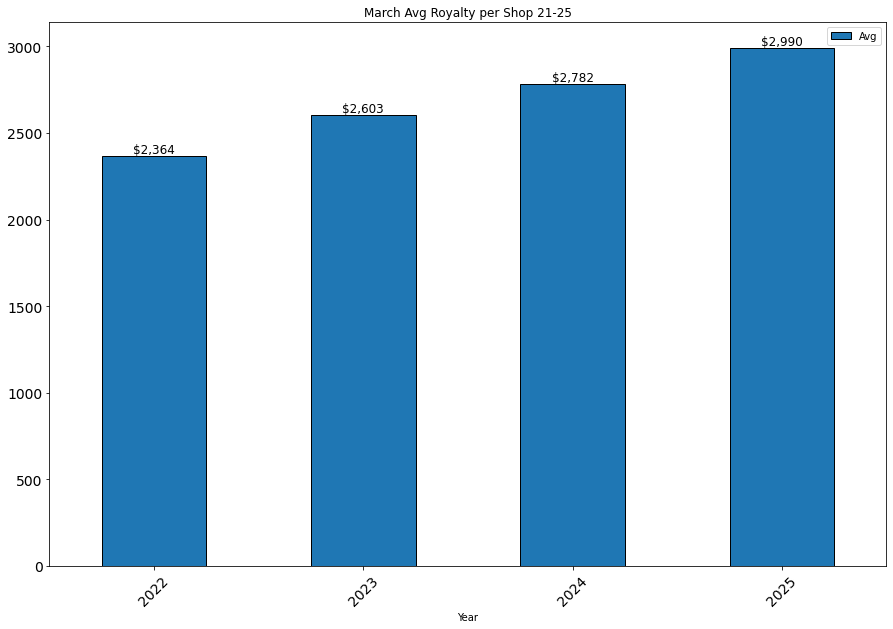

In [33]:
# Current Month Avg Royalty per Shop by Year
df=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','Ext Royalty']].agg({
        'CustomerNo':'nunique',
        'Ext Royalty':'sum'
    }).reset_index()
df['Avg']=round(df.iloc[:,-1].div(df.iloc[:,-2]),1)
df['Year']=df.InvoiceDate.dt.year
ax=df.plot(kind='bar',x='Year',y='Avg',edgecolor='black',
       figsize=(15,10),title=str(month)+' Avg Royalty per Shop 21-25',fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1973797067.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','Ext Royalty']].agg({


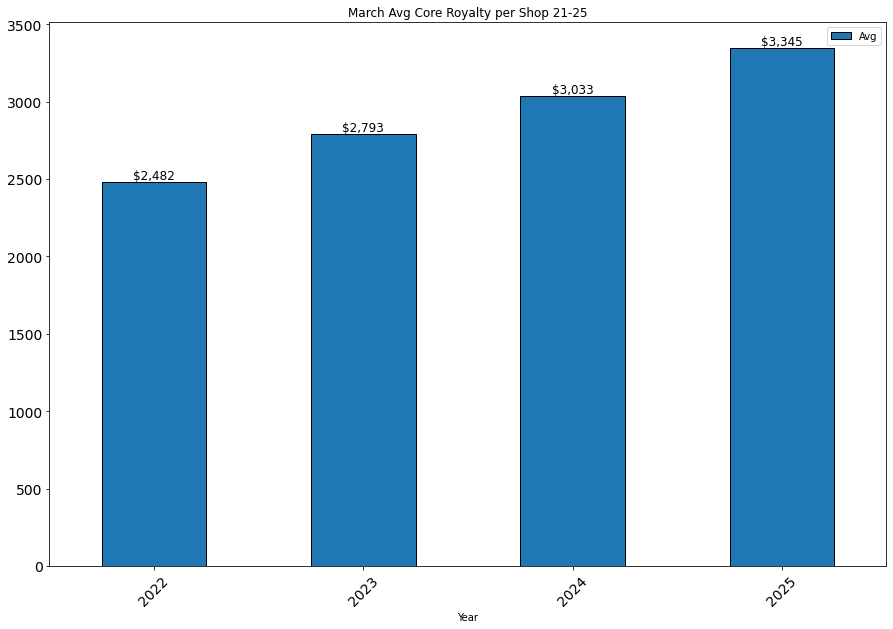

In [34]:
# Current Month Core Shop Royalty by Month by Year
df=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))&(
total_df.BillToState.isin(state))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','Ext Royalty']].agg({
        'CustomerNo':'nunique',
        'Ext Royalty':'sum'
    }).reset_index()
df['Avg']=round(df.iloc[:,-1].div(df.iloc[:,-2]),1)
df['Year']=df.InvoiceDate.dt.year
ax=df.plot(kind='bar',x='Year',y='Avg',edgecolor='black',
       figsize=(15,10),title=str(month)+' Avg Core Royalty per Shop 21-25',fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [35]:
df

InvoiceDate  CustomerNo   Ext Royalty     Avg  Year
0  2022-12-31         357  8.859281e+05  2481.6  2022
1  2023-12-31         366  1.022310e+06  2793.2  2023
2  2024-12-31         381  1.155622e+06  3033.1  2024
3  2025-12-31         373  1.247805e+06  3345.3  2025

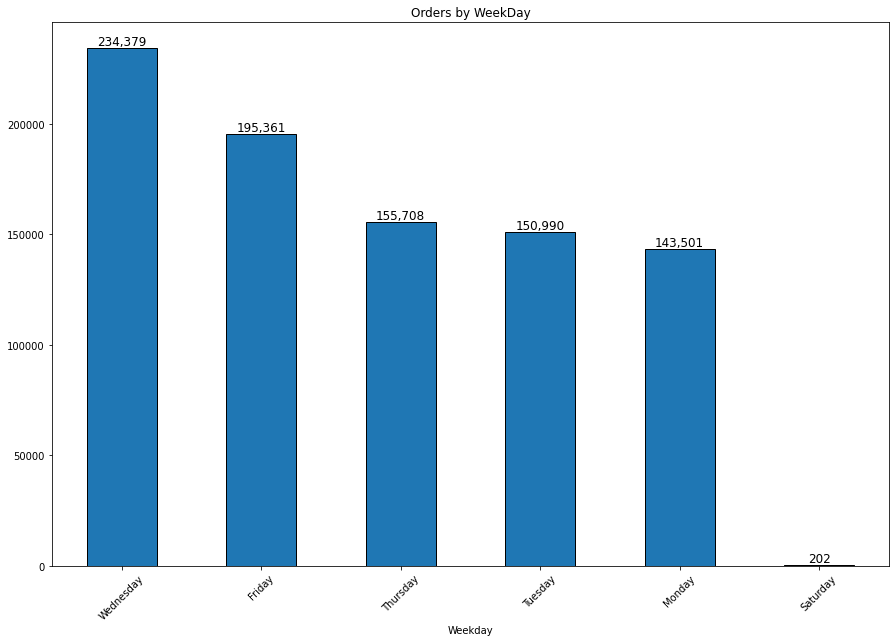

In [36]:
# Orders by Week Day
total_df['Weekday']=total_df.InvoiceDate.dt.strftime('%A')
ax=total_df[total_df.ProductLineDesc.isin(mixes)].groupby('Weekday')['QuantityShipped'].sum().sort_values(ascending=False).plot(
    kind='bar',title='Orders by WeekDay',edgecolor='black',
figsize=(15,10))
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

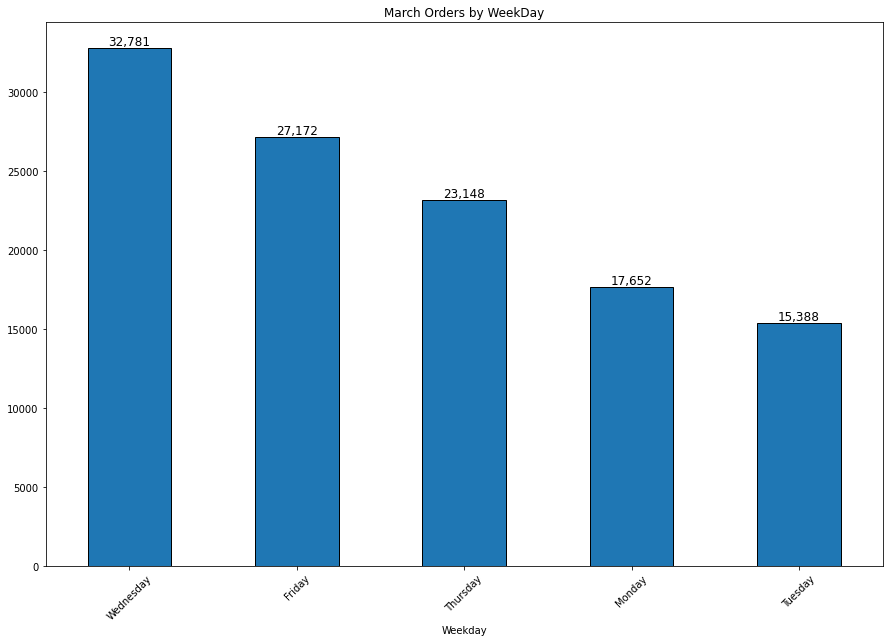

In [37]:
# Current Month Orders by Week Day
ax=total_df[total_df.ProductLineDesc.isin(mixes)&(total_df.InvoiceDate.dt.strftime('%B')==month)].groupby('Weekday')['QuantityShipped'].sum().sort_values(ascending=False).plot(
    kind='bar',title=str(month)+' Orders by WeekDay',edgecolor='black',
figsize=(15,10))
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

<Axes: xlabel='InvoiceDate'>

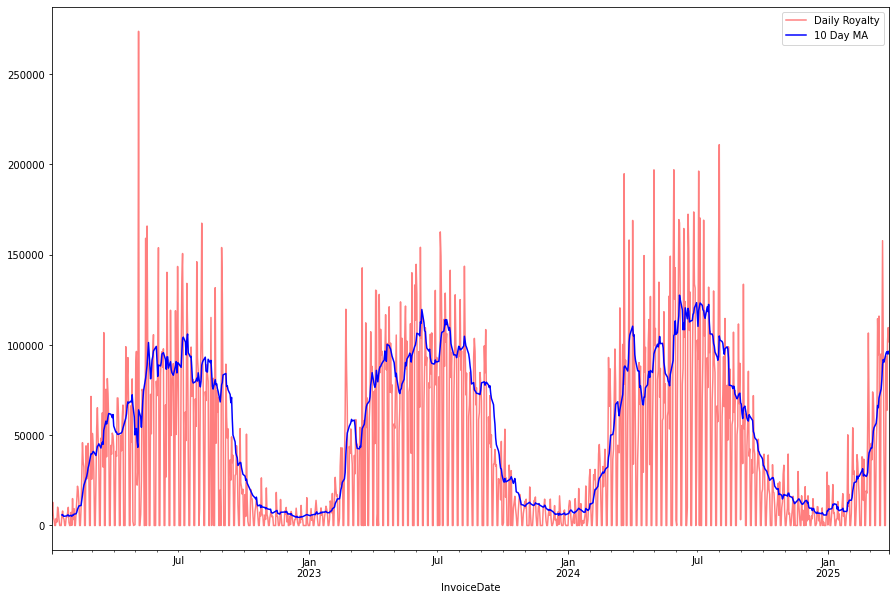

In [38]:
total_df[total_df.InvoiceDueDate.dt.year>=2020].groupby(pd.Grouper(key='InvoiceDate',freq='D'))['Ext Royalty']\
.sum().plot(figsize=(15,10),color='red',label='Daily Royalty',legend=['Daily Royalty'],alpha=.5)
total_df[total_df.InvoiceDueDate.dt.year>=2020].groupby('InvoiceDate')['Ext Royalty'].sum().rolling(10).mean()\
.plot(figsize=(15,10),color='blue',label='10 Day MA',legend=['10 Day MA'])


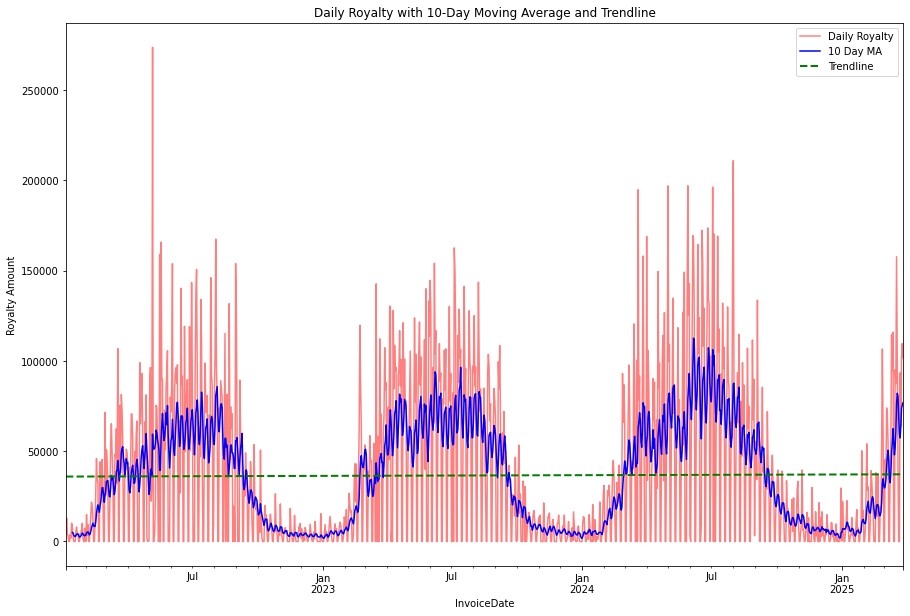

In [39]:

# Filter and group data
daily_data = total_df[total_df.InvoiceDueDate.dt.year >= 2020].groupby(pd.Grouper(key='InvoiceDate', freq='D'))['Ext Royalty'].sum()
rolling_data = daily_data.rolling(10).mean()

# Plot Daily Royalty and 10 Day Moving Average
fig, ax = plt.subplots(figsize=(15, 10))
daily_data.plot(ax=ax, color='red', label='Daily Royalty', alpha=0.5)
rolling_data.plot(ax=ax, color='blue', label='10 Day MA')

# Add Trendline
# Convert dates to a numerical format (e.g., days since start) for polyfit
x_numeric = (daily_data.index - daily_data.index[0]).days
trend = np.polyfit(x_numeric, daily_data.values, 1)  # Linear trendline (degree=1)
trendline = np.polyval(trend, x_numeric)

# Plot the trendline
ax.plot(daily_data.index, trendline, color='green', linestyle='--', linewidth=2, label='Trendline')

# Final adjustments
ax.legend()
ax.set_ylabel('Royalty Amount')
ax.set_title('Daily Royalty with 10-Day Moving Average and Trendline')
plt.show()

In [40]:
rolling=total_df.groupby('InvoiceDate')['QuantityShipped'].sum().rolling(30).mean().reset_index()
rolling['Year']=rolling.InvoiceDate.dt.year
find=rolling.groupby('Year')['QuantityShipped'].max()
max_year=rolling[rolling.QuantityShipped.isin(find)]

In [41]:
max_year

InvoiceDate  QuantityShipped  Year
133  2022-07-14      4975.957333  2022
375  2023-07-10      5157.745067  2023
627  2024-07-15      5385.007667  2024
804  2025-03-28      3075.682667  2025

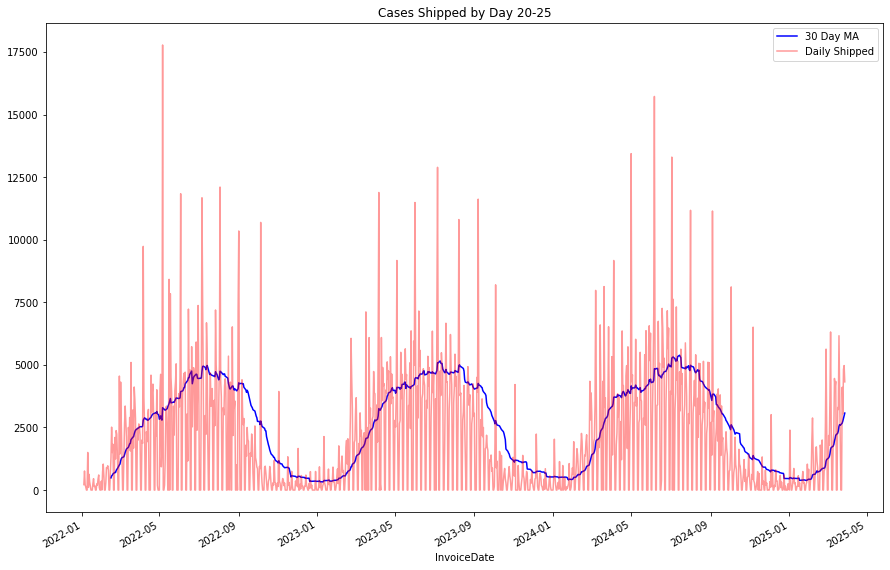

In [42]:
fig,ax=plt.subplots(figsize=(15,10))
# ax=rolling[rolling.QuantityShipped.isin(find)].plot(x=max_year['InvoiceDate'],y=max_year['QuantityShipped'],marker='o')
ax=total_df.groupby('InvoiceDate')['QuantityShipped'].sum().rolling(30).mean().plot(figsize=(15,10),
                                                                                   title='Cases Shipped by Day 20-25',color='blue')
ax=total_df[total_df.InvoiceDueDate.dt.year>=2020].groupby(pd.Grouper(key='InvoiceDate',freq='D'))['QuantityShipped']\
.sum().plot(figsize=(15,10),color='red',alpha=.4)
ax.legend(['30 Day MA','Daily Shipped'])

In [43]:
total_df['Year']=total_df.InvoiceDate.dt.year
from matplotlib.ticker import FormatStrFormatter,StrMethodFormatter
graph=total_df.groupby([pd.Grouper(key='InvoiceDate',freq='M'),'Year'])['Ext Royalty'].sum().reset_index()
graph['Month']=graph.InvoiceDate.dt.strftime('%B')

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\2785381216.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  graph=total_df.groupby([pd.Grouper(key='InvoiceDate',freq='M'),'Year'])['Ext Royalty'].sum().reset_index()


In [44]:
total_df

CustomerNo InvoiceNo InvoiceType   ShipDate InvoiceDate BillToState  \
0               374   1325936          IN 2021-12-30  2022-01-04          DC   
1               374   1325936          IN 2021-12-30  2022-01-04          DC   
2               413   1325937          IN 2021-12-30  2022-01-04          MD   
3               413   1325937          IN 2021-12-30  2022-01-04          MD   
4               413   1325937          IN 2021-12-30  2022-01-04          MD   
...             ...       ...         ...        ...         ...         ...   
1319310          31   1509767          CM 2025-03-27  2025-03-28          PA   
1319311          64   1509768          CM 2025-03-27  2025-03-28          PA   
1319312         164   1509769          CM 2025-03-27  2025-03-28          NJ   
1319313         421   1509770          CM 2025-03-27  2025-03-28          NJ   
1319314         487   1509771          CM 2025-03-27  2025-03-28          NJ   

        InvoiceDueDate ItemCode              ItemCodeDesc ItemType  ...  \
0           2022-02-03     5103          VANILLA CUSTARD         1  ...   
1           2022-02-03     5104            CHOCO CUSTARD         1  ...   
2           2022-02-03     0239    CHPPD REESE'S PB CUPS         1  ...   
3           2022-02-03     0251            WHIPPED CREAM         1  ...   
4           2022-02-03     0264  CHOCO CHIP COOKIE PIECES        1  ...   
...                ...      ...                       ...      ...  ...   
1319310     1753-01-01     3008            PRETZEL BRAID         1  ...   
1319311     1753-01-01     5103          VANILLA CUSTARD         1  ...   
1319312     1753-01-01     3008            PRETZEL BRAID         1  ...   
1319313     1753-01-01     0251            WHIPPED CREAM         1  ...   
1319314     1753-01-01     2776            COCONUT SYRUP         1  ...   

                             CustomerName          City  ARDivisionNo  \
0                  DC RHODE ISLAND AVENUE    Washington            01   
1                  DC RHODE ISLAND AVENUE    Washington            01   
2                    MD HARPERS FARM ROAD      Columbia            01   
3                    MD HARPERS FARM ROAD      Columbia            01   
4                    MD HARPERS FARM ROAD      Columbia            01   
...                                   ...           ...           ...   
1319310                          PA GRANT  Philadelphia            01   
1319311                      PA ROCKLEDGE     Rockledge            01   
1319312                        NJ MEDFORD       Medford            01   
1319313  NJ 4364 J TOWN CNT - WILLINGBORO   Willingboro            01   
1319314                    NJ EAST ORANGE   East Orange            01   

         UDF_ROYALTY_METHOD UDF_DISTRIBUTOR        ProductLineDesc  \
0                  STANDARD         BAL/BUN                CUSTARD   
1                  STANDARD         BAL/BUN                CUSTARD   
2                  STANDARD         BAL/BUN  OTHER INGRED - REFRIG   
3                  STANDARD         BAL/BUN  OTHER INGRED - REFRIG   
4                  STANDARD         BAL/BUN  OTHER INGRED - REFRIG   
...                     ...             ...                    ...   
1319310            STANDARD         BAL/BUN               PRETZELS   
1319311            STANDARD         BAL/BUN                CUSTARD   
1319312            STANDARD         BAL/BUN               PRETZELS   
1319313            STANDARD         BAL/BUN  OTHER INGRED - REFRIG   
1319314            STANDARD         BAL/BUN  OTHER INGRED - REFRIG   

                    OpenDate  StoreStatus  Weekday  Year  
0        2005-08-20 00:00:00         Open  Tuesday  2022  
1        2005-08-20 00:00:00         Open  Tuesday  2022  
2        2006-06-10 00:00:00         Open  Tuesday  2022  
3        2006-06-10 00:00:00         Open  Tuesday  2022  
4        2006-06-10 00:00:00         Open  Tuesday  2022  
...                      ...          ...      ...   ...  
1319310  1994-05

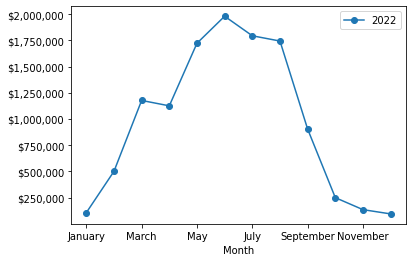

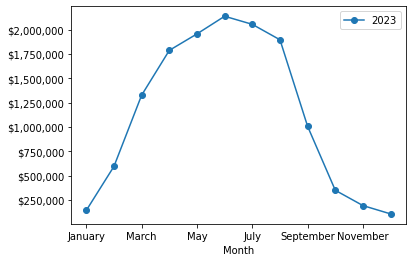

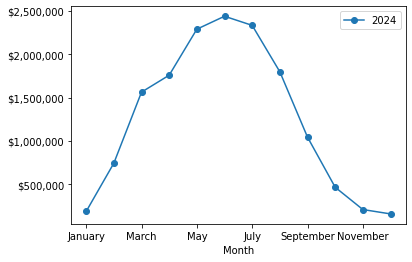

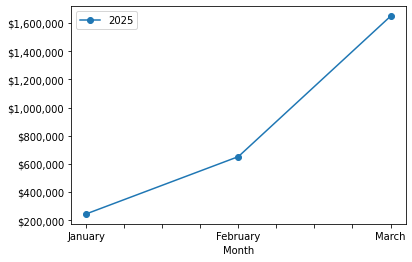

In [45]:
for i in list(enumerate(graph.InvoiceDate.dt.year.unique())):
    ax=graph[graph.Year==i[1]].plot(x='Month',y='Ext Royalty',legend=i[1],marker='o')
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    ax.legend([i[1]])

# Code Below Creates the Invoice Report
- Looking at Product Revenue and Royalties
- Creates Four Pivot tables, two each for Product Revenue and Royalty
- Pivot tables show Product Revenue and Royalty by Week by Shop and by Month by Shop
- The totals for Weekly and Monthly Product revenues should be equal, as well as the Royalty totals
- The totals for these reports will not match what we report on our P/L. That is for several reasons, mostly because these\
  reports are Cash Basis, while our Financial Reports are accraul.
- However, they will be very close to the P/L and at the very least give an indication of how the month is trending
- This report will print out to the folder below and be sent to Bill every Monday
- It's better to wait until Melissa is done her billing, usually around Noon on Mondays before running and sending out

In [46]:
timestamp=date.today().strftime('%m-%d-%y')
state=['PA','NJ','DE','MD']
ytd_royalty=total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='M'),
                                                                values='Ext Royalty',
                                                                aggfunc='sum',fill_value=0)
weekly=total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='W'),
                                                                values='Ext Royalty',
                                                                aggfunc='sum',fill_value=0)
ytd_revenue=total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='M'),
                                                                values='Ext Base Cost',
                                                                aggfunc='sum',fill_value=0)
weekly_revenue=total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='W'),
                                                                values='Ext Base Cost',
                                                                aggfunc='sum',fill_value=0)
columns=ytd_royalty.columns.strftime('%B')
ytd_royalty.columns=columns
columns=ytd_revenue.columns.strftime('%B')
ytd_revenue.columns=columns
w_columns=list(range(1,len(weekly.columns)+1))
weekly.columns=w_columns
weekly=weekly.add_prefix('Wk')
w_columns_rev=list(range(1,len(weekly_revenue.columns)+1))
weekly_revenue.columns=w_columns_rev
weekly_revenue=weekly_revenue.add_prefix('Wk')
ytd_royalty['Total']=ytd_royalty.sum(axis=1)
weekly['Total']=weekly.sum(axis=1)
ytd_revenue['Total']=ytd_revenue.sum(axis=1)
weekly_revenue['Total']=weekly_revenue.sum(axis=1)
# weekly_revenue.loc['Total']=weekly_revenue.iloc[:,0:].sum(axis=0)
# weekly.loc['Total']=weekly.iloc[:,0:].sum(axis=0)
# ytd_royalty.loc['Total']=ytd_royalty.iloc[:,0:].sum(axis=0)
# ytd_revenue.loc['Total']=ytd_revenue.iloc[:,0:].sum(axis=0)
# ytd_state=ytd_royalty.reset_index().set_index(['CustomerNo','CustomerName'])
# core=ytd_state[ytd_state.BillToState.isin(state)]
# dev=ytd_state[~ytd_state.BillToState.isin(state)]
text1='Ritas Franchise Operations,LLC'
text2='Royalty Revenue Report-By Week'
text3='Royalty Revenue Report-By Month'
text4='Product Revenue Report-By Week'
text5='Product Revenue Report-By Month'
text6='Through '+str(date.today().strftime('%m-%d-%y'))
text7='Source Code: MAS_RFC AR_InvoiceHistoryHeader, AR_Customer, AR_InvoiceHistoryDetail, IM_ProductLine'

writer=pd.ExcelWriter('Bill Royalty 2025 '+str(total_df.InvoiceDate.max().strftime('%m-%d-%y'))+' '+str(timestamp)+'.xlsx',
                      datetime_format='mm/dd/yyyy',engine='xlsxwriter')
weekly.to_excel(writer, startrow=6,startcol=0,sheet_name='Weekly Royalty')
ytd_royalty.to_excel(writer,startrow=6,startcol=0,sheet_name='Monthly Royalty')
weekly_revenue.to_excel(writer,startrow=6,startcol=0,sheet_name='Weekly Product Revenue')
ytd_revenue.to_excel(writer,startrow=6,startcol=0,sheet_name='Monthly Product Revenue')
workbook=writer.book
worksheet_1=writer.sheets['Weekly Royalty']
worksheet_2=writer.sheets['Monthly Royalty']
worksheet_3=writer.sheets['Weekly Product Revenue']
worksheet_4=writer.sheets['Monthly Product Revenue']
format_1=workbook.add_format({'num_format':'$#,##0.00'})
header_format=workbook.add_format({'bold':True,
                                  'italic':True})
border_format=workbook.add_format({'right':1,'left':1,'bottom':1,'top':1})
date_format=workbook.add_format({'num_format':'m/d/yyyy'})

# Row banding Format(Alternate based on Odd-Even Row Number)
odd_row_format = workbook.add_format({'bg_color': '#E2EFDA'})  # Light Green for odd rows
even_row_format = workbook.add_format({'bg_color': '#FFFFFF'})  # White for even rows


worksheet_1.set_column('A:BZ',12,format_1)
worksheet_1.set_column('B:B',42)
worksheet_1.set_column('D:D',18,date_format)
worksheet_1.write(0,1,text1,header_format)
worksheet_1.write(1,1,text2,header_format)
worksheet_1.write(2,1,text6,header_format)
worksheet_1.write(3,1,text7,header_format)
worksheet_1.conditional_format(xlsxwriter.utility.xl_range(6,0,len(weekly)+6,len(weekly.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_1.conditional_format(6, 0, len(weekly) + 6, len(weekly.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_1.conditional_format(6, 0, len(weekly) + 6, len(weekly.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })


worksheet_1.hide_gridlines(2)
worksheet_1.insert_image('A1','Logo.png')

worksheet_2.set_column('A:BZ',12,format_1)
worksheet_2.set_column('B:B',42)
worksheet_2.set_column('D:D',18,date_format)
worksheet_2.write(0,1,text1,header_format)
worksheet_2.write(1,1,text3,header_format)
worksheet_2.write(2,1,text6,header_format)
worksheet_2.write(3,1,text7,header_format)
worksheet_2.conditional_format(xlsxwriter.utility.xl_range(6,0,len(ytd_royalty)+6,len(ytd_royalty.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_2.conditional_format(6, 0, len(ytd_royalty) + 6, len(ytd_royalty.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_2.conditional_format(6, 0, len(ytd_royalty) + 6, len(ytd_royalty.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
worksheet_2.hide_gridlines(2)

worksheet_3.set_column('A:BZ',12,format_1)
worksheet_3.set_column('B:B',42)
worksheet_3.set_column('D:D',18,date_format)
worksheet_3.write(0,1,text1,header_format)
worksheet_3.write(1,1,text4,header_format)
worksheet_3.write(2,1,text6,header_format)
worksheet_3.write(3,1,text7,header_format)
worksheet_3.conditional_format(xlsxwriter.utility.xl_range(6,0,len(weekly_revenue)+6,len(weekly_revenue.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_3.conditional_format(6, 0, len(weekly_revenue) + 6, len(weekly_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_3.conditional_format(6, 0, len(weekly_revenue) + 6, len(weekly_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
worksheet_3.hide_gridlines(2)

worksheet_4.set_column('A:BZ',12,format_1)
worksheet_4.set_column('B:B',42)
worksheet_4.set_column('D:D',18,date_format)
worksheet_4.write(0,1,text1,header_format)
worksheet_4.write(1,1,text5,header_format)
worksheet_4.write(2,1,text6,header_format)
worksheet_4.write(3,1,text7,header_format)
worksheet_4.conditional_format(xlsxwriter.utility.xl_range(6,0,len(ytd_revenue)+6,len(ytd_revenue.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_4.conditional_format(6, 0, len(ytd_revenue) + 6, len(ytd_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_4.conditional_format(6, 0, len(ytd_revenue) + 6, len(ytd_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
worksheet_4.hide_gridlines(2)

worksheet_2.insert_image('A1','Logo.png')
worksheet_3.insert_image('A1','Logo.png')
worksheet_4.insert_image('A1','Logo.png')

writer.close()

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1906131667.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  columns=pd.Grouper(key='InvoiceDate',freq='M'),
C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1906131667.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  columns=pd.Grouper(key='InvoiceDate',freq='M'),


In [47]:
os.getcwd()

'G:\\FinanceReports\\2025\\Wk13'

In [48]:

total_df=total_df[total_df['OpenDate']!='No Open Date']


total_df['OpenDate']=pd.to_datetime(total_df['OpenDate'])
years=[2021,2022,2023,2024,2025]

with pd.ExcelWriter('NSO Case Orders '+str(total_df.InvoiceDate.max().strftime('%m-%d-%y'))+' '+str(timestamp)+'.xlsx',engine='xlsxwriter',datetime_format='mm/dd/yyyy') as writer:
    for i in list(enumerate(years)): 
        nso=total_df[(total_df.OpenDate.dt.year==i[1])&(total_df.InvoiceDate.dt.month<=date.today().month)&(
        total_df.ProductLineDesc.isin(mixes))].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate','StoreStatus'],
                                                                columns=total_df.InvoiceDate.dt.year,
                                                                 values='QuantityShipped',
                                                                 aggfunc='sum',fill_value=0).reset_index()
        
        nso.to_excel(writer, sheet_name=str(i[1])+' New Shop Orders',startrow=5,startcol=0,index=False)
        wb=writer.book
        vol_format=wb.add_format({'num_format':'#,##0.0',
                                 'align':'center',
                                 'valign':'vcenter'})
        border_format=wb.add_format({'top':2,'bottom':2,'left':2,'right':2})
        align=wb.add_format({'align':'center',
                            'valign':'vcenter'})
        ws=writer.sheets[str(i[1])+' New Shop Orders']
        title='Ritas Franchise Company,LLC'
        title1=str(i[1])+' New Shop Mix & Custard Case Orders'
        title2='Case Orders thru '+(str(total_df.InvoiceDate.max().strftime('%m/%d/%y')))
        title3='Source Code: Invoice History Detail'
        header_format=wb.add_format({'bold':True,
                                    'italic':True})
        # Row banding Format(Alternate based on Odd-Even Row Number)
        odd_row_format = wb.add_format({'bg_color': '#FFFFFF'})  # White for odd rows
        even_row_format = wb.add_format({'bg_color': '#E2EFDA'})  # Light Green for even rows
        
        ws.conditional_format(xlsxwriter.utility.xl_range(5,0,len(nso)+5,len(nso.columns)-1),
                              {'type': 'no_errors', 'format': border_format})
        
        # Apply alternating row colors using a single conditional format
        ws.conditional_format(5, 0, len(nso) + 5, len(nso.columns) -1, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
        ws.conditional_format(5, 0, len(nso) + 5, len(nso.columns) -1, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
        ws.write(0,1,title,header_format)
        ws.write(1,1,title1,header_format)
        ws.write(2,1,title2,header_format)
        ws.write(3,1,title3,header_format)
        ws.set_column('A:H',12,align)
        ws.set_column('B:B',45,align)
        ws.set_column('E:E',18.2,align)
        ws.set_column('F:I',12,vol_format)
        ws.hide_gridlines(2)
        ws.insert_image('A1','Logo.png')
       

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\613952947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['OpenDate']=pd.to_datetime(total_df['OpenDate'])


In [49]:
pd.set_option('display.max_columns', 500)
total_df[(total_df.ItemCodeDesc=='VANILLA CUSTARD ')]\
.groupby(pd.Grouper(key='InvoiceDate',freq='Y'))['UDF_STD_UNIT_PRICE'].agg(['mean','median','max','min'])

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\193376767.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .groupby(pd.Grouper(key='InvoiceDate',freq='Y'))['UDF_STD_UNIT_PRICE'].agg(['mean','median','max','min'])


mean  median    max    min
InvoiceDate                                 
2022-12-31   68.753119   68.99  68.99  62.38
2023-12-31   72.846254   74.10  74.10  68.99
2024-12-31   70.901721   70.89  71.26  70.89
2025-12-31   77.316940   78.60  78.60  70.89

In [50]:
# text1='Ritas Franchise Operations,LLC'
# text2='Vanilla Custrard Orders through July'
# text3='For Years 2023 and 2024'
# text4='Source Code: MAS_RFC AR_InvoiceHistoryHeader, AR_Customer, AR_InvoiceHistoryDetail, IM_ProductLine'
# writer2=pd.ExcelWriter('Vanilla Custard Orders July Only.xlsx',datetime_format='mm/dd/yyyy')
# total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)]\
# .pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
#                                                                 columns=[total_df.InvoiceDate.dt.year,'ItemCodeDesc'],
#                                                                 values='QuantityShipped',
#                                                                 aggfunc='sum',fill_value=0).filter(regex='VANILLA CUSTARD')\
# .to_excel(writer2, sheet_name='July Orders Comp',startrow=5,startcol=0)
# workbook=writer2.book
# worksheet_1=writer2.sheets['July Orders Comp']
# format_1=workbook.add_format({'num_format':'#,##0.0'})
# header_format=workbook.add_format({'bold':True,
#                                   'italic':True})
# worksheet_1.set_column('A:AZ',12,format_1)
# worksheet_1.set_column('B:B',42)
# worksheet_1.write(0,1,text1,header_format)
# worksheet_1.write(1,1,text2,header_format)
# worksheet_1.write(2,1,text3,header_format)
# worksheet_1.write(3,1,text4,header_format)
# worksheet_1.insert_image('A1','Logo.png')
# writer2.close()

In [51]:
# total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)&(total_df.ProductLineDesc.isin(mixes))]\
# .pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='UDF_STD_UNIT_PRICE',
#                                                                 aggfunc='mean',fill_value=0).to_excel('Test2.xlsx')

In [52]:
# mix=total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)&(total_df.ProductLineDesc.isin(mixes))]\
# .pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='QuantityShipped',
#                                                                 aggfunc='sum',fill_value=0).apply(lambda x:x/sum(x))\
# .reset_index()
# median=total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)&(total_df.ProductLineDesc.isin(mixes))]\
# .pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='UDF_STD_UNIT_PRICE',
#                                                                 aggfunc='median',fill_value=0).reset_index()
# mix.merge(median,on='ItemCodeDesc',suffixes=['_Mix','_Median']).to_excel('Test3.xlsx',index=False)

In [53]:
total_df['Month']=total_df.InvoiceDate.dt.strftime('%B')
total_df['Month_Num']=total_df.InvoiceDate.dt.month

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\22577313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['Month']=total_df.InvoiceDate.dt.strftime('%B')
C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\22577313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['Month_Num']=total_df.InvoiceDate.dt.month


In [54]:
yearly=total_df[total_df.InvoiceDate.dt.year>=2023]\
.groupby(['Month_Num','Month',total_df.InvoiceDate.dt.year])['Ext Royalty'].sum().reset_index().sort_values(by='Month_Num')

In [55]:
yearly

Month_Num      Month  InvoiceDate   Ext Royalty
0           1    January         2023  1.436604e+05
1           1    January         2024  1.868014e+05
2           1    January         2025  2.455545e+05
3           2   February         2023  5.960525e+05
4           2   February         2024  7.435863e+05
5           2   February         2025  6.521835e+05
6           3      March         2023  1.327119e+06
7           3      March         2024  1.562879e+06
8           3      March         2025  1.648591e+06
9           4      April         2023  1.787328e+06
10          4      April         2024  1.758067e+06
11          5        May         2023  1.956606e+06
12          5        May         2024  2.282665e+06
14          6       June         2024  2.412773e+06
13          6       June         2023  2.137925e+06
15          7       July         2023  2.054799e+06
16          7       July         2024  2.329295e+06
17          8     August         2023  1.896092e+06
18          8     August         2024  1.792888e+06
19          9  September         2023  1.006238e+06
20          9  September         2024  1.042778e+06
21         10    October         2023  3.500335e+05
22         10    October         2024  4.660354e+05
23         11   November         2023  1.931017e+05
24         11   November         2024  2.090731e+05
25         12   December         2023  1.076586e+05
26         12   December         2024  1.586259e+05

In [56]:
total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='M'),
                                                                values='Ext Royalty',
                                                                aggfunc='sum',fill_value=0)

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\3718078626.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  columns=pd.Grouper(key='InvoiceDate',freq='M'),


InvoiceDate                                                         2025-01-31  \
CustomerNo CustomerName                     BillToState OpenDate                 
1          PA 1227 BRISTOL PIKE - WOODHAVEN PA          1984-05-04        0.00   
2          PA ACADEMY                       PA          1987-04-01        0.00   
3          PA RISING SUN                    PA          1988-06-01        0.00   
4          PA PINE VALLEY                   PA          1990-04-06        0.00   
6          PA RHAWN                         PA          1990-06-21        0.00   
...                                                                        ...   
5036       PHL BICUTAN SUPERMALL                        2024-08-03      110.95   
5037       PHL NORTH EDSA SUPERMALL                     2024-06-25      218.46   
5038       PHL UPTOWN MALL                              2024-09-05      367.01   
5039       PHL VENICE GRAND CANAL MALL                  2025-02-14        0.00   
15031      PHL FESTIVAL SUPERMALL SATELLITE             2024-03-25      236.30   

InvoiceDate                                                         2025-02-28  \
CustomerNo CustomerName                     BillToState OpenDate                 
1          PA 1227 BRISTOL PIKE - WOODHAVEN PA          1984-05-04     1986.56   
2          PA ACADEMY                       PA          1987-04-01     1834.89   
3          PA RISING SUN                    PA          1988-06-01      481.41   
4          PA PINE VALLEY                   PA          1990-04-06     1307.88   
6          PA RHAWN                         PA          1990-06-21        0.00   
...                                                                        ...   
5036       PHL BICUTAN SUPERMALL                        2024-08-03       83.73   
5037       PHL NORTH EDSA SUPERMALL                     2024-06-25      202.93   
5038       PHL UPTOWN MALL                              2024-09-05      295.08   
5039       PHL VENICE GRAND CANAL MALL                  2025-02-14      287.11   
15031      PHL FESTIVAL SUPERMALL SATELLITE             2024-03-25      210.35   

InvoiceDate                                                         2025-03-31  
CustomerNo CustomerName                     BillToState OpenDate                
1          PA 1227 BRISTOL PIKE - WOODHAVEN PA          1984-05-04     3302.34  
2          PA ACADEMY                       PA          1987-04-01     5384.19  
3          PA RISING SUN                    PA          1988-06-01     3411.97  
4          PA PINE VALLEY                   PA          1990-04-06     1837.27  
6          PA RHAWN                         PA          1990-06-21       46.84  
...                                                                        ...  
5036       PHL BICUTAN SUPERMALL                        2024-08-03        0.00  
5037       PHL NORTH EDSA SUPERMALL                     2024-06-25        0.00  
5038       PHL UPTOWN MALL                              2024-09-05        0.00  
5039       PHL VENICE GRAND CANAL MALL                  2025-02-14        0.00  
15031      PHL FESTIVAL SUPERMALL SATELLITE             2024-03-25        0.00  

[555 rows x 3 columns]

In [57]:
total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns='Month',
                                                                values='Ext Royalty',
                                                                aggfunc='sum',fill_value=0,margins=True).to_excel('test.xlsx')

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\1720848141.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  total_df[total_df.InvoiceDate.dt.year==2025].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],


In [58]:
total_df[total_df.CustomerName=='FL 1731 LAKEWOOD RANCH BLVD-BRADENTON']

CustomerNo InvoiceNo InvoiceType   ShipDate InvoiceDate BillToState  \
796535         1502   1434604          IN 2023-10-25  2023-10-25          FL   
810848         1502   1436522          IN 2023-12-07  2023-12-12          FL   
810849         1502   1436522          IN 2023-12-07  2023-12-12          FL   
810850         1502   1436522          IN 2023-12-07  2023-12-12          FL   
810851         1502   1436522          IN 2023-12-07  2023-12-12          FL   
...             ...       ...         ...        ...         ...         ...   
1308698        1502   1507268          IN 2025-03-21  2025-03-24          FL   
1308699        1502   1507268          IN 2025-03-21  2025-03-24          FL   
1308700        1502   1507268          IN 2025-03-21  2025-03-24          FL   
1308701        1502   1507268          IN 2025-03-21  2025-03-24          FL   
1308702        1502   1507268          IN 2025-03-21  2025-03-24          FL   

        InvoiceDueDate ItemCode              ItemCodeDesc ItemType  UnitPrice  \
796535      2023-11-09     2059                   SCANNER        1      60.00   
810848      2024-01-11     0117                MANGO MIX         1     159.03   
810849      2024-01-11     0312       WAX PRETZEL PAPERS         1      83.78   
810850      2024-01-11     0322         2 OZ SOUFFLE LID         1      30.72   
810851      2024-01-11     0327  2 OZ SOUFFLE CUP PLASTIC        1      43.18   
...                ...      ...                       ...      ...        ...   
1308698     2025-04-13     0903            CONTAINER LID         1      24.45   
1308699     2025-04-13     1128          24" FRENCH  WHIP        1       6.59   
1308700     2025-04-13     7021          TREAT TEAM VISOR        1       7.45   
1308701     2025-04-13     7024    TT SOLID SHIRT MEDIUM         1      42.86   
1308702     2025-04-13     7025     TT SOLID SHIRT LARGE         1      42.86   

         QuantityShipped  UDF_ROYALTY_AMT  UDF_STD_UNIT_PRICE ProductLine  \
796535               2.0             0.00               60.00        NR16   
810848               1.0            69.19               57.90        RO01   
810849               1.0             0.00               83.78        NR03   
810850               1.0             0.00               30.72        NR03   
810851               1.0             0.00               43.18        NR03   
...                  ...              ...                 ...         ...   
1308698              1.0             0.00               24.45        NR07   
1308699              1.0             0.00                6.59        NR07   
1308700              3.0             0.00                7.45        NR06   
1308701              1.0             0.00               42.86        NR06   
1308702              1.0             0.00               42.86        NR06   

        CommentText  Ext Base Cost  Ext Royalty  \
796535                      120.00         0.00   
810848                       57.90        69.19   
810849                       83.78         0.00   
810850                       30.72         0.00   
810851                       43.18         0.00   
...             ...            ...          ...   
1308698                      24.45         0.00   
1308699                       6.59         0.00   
1308700                      22.35         0.00   
1308701                      42.86         0.00   
1308702                      42.86         0.00   

                                  CustomerName       City ARDivisionNo  \
796535   FL 1731 LAKEWOOD RANCH BLVD-BRADENTON  Bradenton           01   
810848   FL 1731 LAKEWOOD RANCH BLVD-BRADENTON  Bradenton           01   
810849   FL 1731 LAKEWOOD RANCH BLVD-BRADENTON  Bradenton           01   
810850   FL 1731 LAKEWOOD RANCH BLVD-BRADENTON  Bradenton           01   
810851   FL 1731 LAKEWOOD RANCH BLVD-BRADENTON  Bradenton           01   
...                                        ...        ...          ...   
1308698  FL 1731 LA

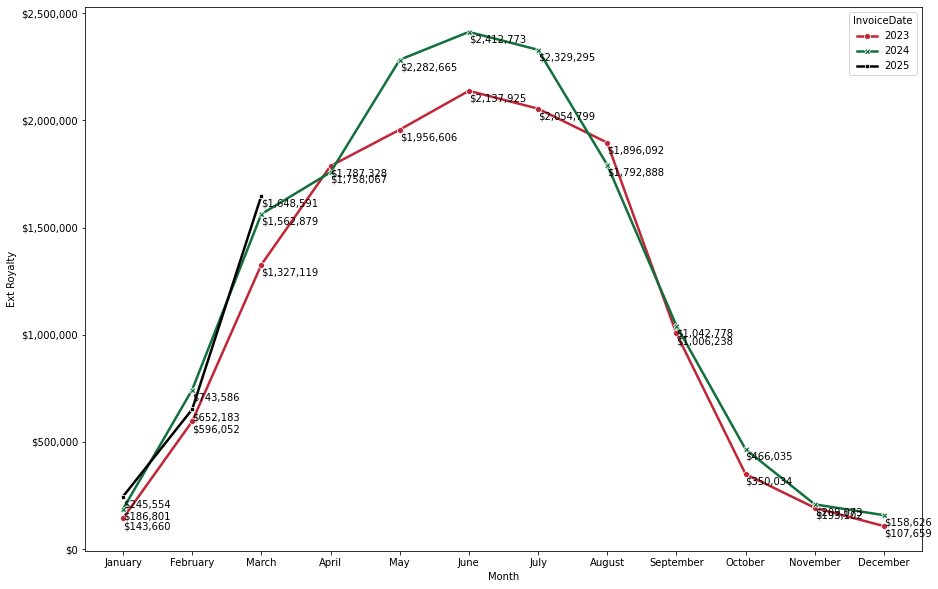

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=yearly, x='Month',y='Ext Royalty',hue='InvoiceDate',palette=['#C12637','#12703C','#000000'],
            markers=True,dashes=False,linewidth=2.5,style='InvoiceDate')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for x,y in zip(yearly.Month,yearly['Ext Royalty']):
    plt.text(x=x, y=y-50000, s='${:,.0f}'.format(y))

In [60]:
import plotly.graph_objects as go

# Example DataFrame setup (assuming yearly is already defined as a DataFrame)
# yearly = pd.DataFrame(...)  # your DataFrame with Month, Ext Royalty, InvoiceDate columns

# Initialize the Plotly figure
fig = go.Figure()

# Loop through unique InvoiceDate to create traces for each hue
for invoice_date in yearly['InvoiceDate'].unique():
    filtered_data = yearly[yearly['InvoiceDate'] == invoice_date]
    
    # Add line trace for each InvoiceDate
    fig.add_trace(go.Scatter(
        x=filtered_data['Month'],
        y=filtered_data['Ext Royalty'],
        mode='lines+markers+text',
        name=str(invoice_date),  # Legend entry
        text=[f'${value:,.0f}' for value in filtered_data['Ext Royalty']],  # Display values as text
        textposition='bottom center',  # Position text below the markers
        line=dict(width=2.5),
        marker=dict(size=8)
    ))

# Customize layout
fig.update_layout(
    title='Ext Royalty by Month',
    xaxis_title='Month',
    yaxis_title='Ext Royalty',
    yaxis_tickprefix='$',  # Add dollar sign prefix
    yaxis_tickformat=',',  # Format y-axis ticks with commas
    width=1000,
    height=900,
)

# Show the interactive plot
fig.show()

In [61]:
product_orders=total_df[total_df.InvoiceDate.dt.year>=2023]\
.groupby(['Month_Num','Month',total_df.InvoiceDate.dt.year])['Ext Base Cost'].sum().reset_index().sort_values(by='Month_Num')

product_orders=product_orders.rename(columns={'InvoiceDate':'Year'})
fig=go.Figure()

for i in product_orders.Year.unique():
    filtered_products=product_orders[product_orders.Year==i]
    
    fig.add_trace(go.Scatter(
        x=filtered_products.Month,
        y=filtered_products['Ext Base Cost'],
        mode='lines+markers+text',
        name=str(i),
        line=dict(width=2.5),
        marker=dict(size=8),
        text=[f'${j:,.0f}' for j in filtered_products['Ext Base Cost']],
        textposition='top center',
        textfont=dict(size=10)
    ))
    
fig.update_layout(title=dict(text='Product Revenue By Month',font=dict(size=16)),
                    xaxis_title='Month',
                    yaxis_title='Product Revenue',
                    yaxis_tickprefix='$',
                    yaxis_tickformat=',',
                    height=1000,
                    width=900
                     )
fig.show()


In [62]:
product_orders

Month_Num      Month  Year  Ext Base Cost
0           1    January  2023   3.700061e+05
1           1    January  2024   4.405764e+05
2           1    January  2025   5.074930e+05
3           2   February  2023   1.531773e+06
4           2   February  2024   1.782804e+06
5           2   February  2025   1.621444e+06
6           3      March  2023   3.458410e+06
7           3      March  2024   3.653986e+06
8           3      March  2025   3.940425e+06
9           4      April  2023   4.441330e+06
10          4      April  2024   4.125412e+06
11          5        May  2023   4.931016e+06
12          5        May  2024   5.274710e+06
14          6       June  2024   5.380025e+06
13          6       June  2023   5.385523e+06
15          7       July  2023   4.958829e+06
16          7       July  2024   5.266223e+06
17          8     August  2023   4.617839e+06
18          8     August  2024   4.013187e+06
19          9  September  2023   2.403975e+06
20          9  September  2024   2.410747e+06
21         10    October  2023   8.675294e+05
22         10    October  2024   1.089179e+06
23         11   November  2023   4.634409e+05
24         11   November  2024   4.155235e+05
25         12   December  2023   3.480676e+05
26         12   December  2024   3.415709e+05

In [63]:
fig = go.Figure(data=go.Scatter(x=[1, 2, 3, 4], y=[10, 15, 13, 17]))

fig.update_layout(
    title="Customized Layout Example",
    xaxis=dict(title="X Axis", tickformat=".1f"),
    yaxis=dict(title="Y Axis", range=[0, 20]),
    showlegend=False,
    paper_bgcolor="lightblue",
    plot_bgcolor="white",
    margin=dict(l=50, r=50, t=100, b=50),
    annotations=[dict(x=3, y=15, text="Highlight", showarrow=True, arrowhead=1)]
)

fig.show()


In [64]:
total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=12)&(total_df.ProductLineDesc.isin(mixes))]\
.pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='UDF_STD_UNIT_PRICE',
                                                                aggfunc='median',fill_value=0)

InvoiceDate                       2023    2024    2025
ItemCodeDesc                                          
2.5 GAL CHOCO CUST CREDIT        36.79   35.63   37.71
2.5 GAL VANILLA CUST CREDIT      37.05   35.45   39.30
BANANA MIX                       53.24   59.05   60.73
BIRTHDAY CAKE MIX                61.98   68.76   70.69
BLUEBERRY/BLUE RASP              51.52   55.07   57.33
CANTALOUPE MIX                   66.53   80.23    0.00
CHEESECAKE MIX                   65.52   81.75    0.00
CHERRY MIX                       63.36   68.56   69.74
CHOCO CUSTARD                    73.57   71.26   79.58
CHOCOLATE MIX                    55.97   61.21   73.88
CITRUS BLAST MIX                 59.39    0.00    0.00
COCONUT CREAM MIX                48.65   57.83   60.41
COLA MIX                          0.00    0.00   52.99
COOKIES N' CREAM MIX             51.11   56.56   58.10
COTTON CANDY MIX                 68.33   69.12   72.39
CY POWDER CHOCO CUSTARD           0.00  133.51  174.12
CY POWDER VANILLA CUSTARD         0.00  132.20  151.99
DISCOUNT PINEAPPLE MIX            0.00    0.00   34.40
DR.PEPPER MIX                   109.00  118.30  114.67
FLORIDA ORANGE MIX               68.53   98.83   98.83
GRAPE MIX                        95.95   95.95    0.00
GREEN APPLE                      57.80   63.22   65.18
GUAVA PASSION FRUIT MIX -4/1 G   61.29    0.00    0.00
GUMMY BEAR MIX                   61.56   61.56    0.00
ISLAND FUSION MIX                68.48   79.43   81.38
JUICY PEAR MIX                   63.53   68.27   71.86
KEY LIME MIX                     52.10   59.17   65.33
KLEINS CHOCO CUSTARD              0.00    0.00    0.00
KLEINS VANILLA CUSTARD            0.00    0.00    0.00
KOOL AID MIX                      0.00   54.16   54.77
LEMON BASE                       44.48   51.26   55.21
MANGO MIX                        57.90   61.88   64.94
MINT CHOC CHIP CRM MIX           51.03   60.54   62.62
NERDS MIX                         0.00   56.12   55.84
NEW GEORGIA PEACH MIX            69.85   76.60   77.35
OATLY VANILLA SOFT SERVE         48.26    0.00    0.00
OCEAN SPLASH                    110.59  125.91    0.00
PINA COLADA MIX                  47.92   56.63   57.32
PINEAPPLE MIX                    61.22   68.03   68.03
PUMPKIN MIX                      70.98   84.30    0.00
RASPBERRY MIX                   124.39  119.20  119.20
ROOT BEER MIX                    49.47   58.34   59.91
S'MORES MIX                      66.80   74.32   76.13
SKITTLES MIX                      0.00    0.00   58.33
SOUR PATCH KIDS MIX              60.44   68.26   70.52
SOUR PATCH WATERMELON             0.00   82.98   83.96
STRAWBERRY MIX                   59.22   63.17   66.70
SWEDISH FISH MIX                 61.40   66.40   67.10
TANGERINE MIX                    61.94    0.00    0.00
TROPICAL PUNCH MIX               74.15   74.15    0.00
UNICORN MIX                     109.34  125.02    0.00
VANILLA CUSTARD                  74.10   70.89   78.60
VANILLA MIX                      48.76   56.53   60.37
WATERMELON MIX                   49.19   54.77   57.60
WILD BLACK CHERRY MIX            67.24   72.22   75.01

In [65]:
# total_df['Year']=total_df.InvoiceDate.dt.year
# total_df['Month']=total_df.InvoiceDate.dt.strftime('%B')
# hist_royalty=total_df.pivot_table(index=['Year'],
#                                                                 columns='Month',
#                                                                 values='Ext Royalty',
#                                                                 aggfunc='sum',fill_value=0)

# hist_royalty.to_excel('Historical Royalty.xlsx')

In [66]:
total_df.InvoiceDate.max()

Timestamp('2025-03-28 00:00:00')

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
season=total_df.groupby(pd.Grouper(key='InvoiceDate',freq='M'))['QuantityShipped'].sum().reset_index()
season=season.set_index('InvoiceDate')
results=seasonal_decompose(season.QuantityShipped,model='additive')
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

C:\Users\jharned\AppData\Local\Temp\ipykernel_7664\3814539429.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



ValueError: freq ME not understood. Please report if you think this is in error.

In [ ]:
results.trend.plot()